In [2]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.special import gamma

from matplotlib.cm import rainbow
from joblib import Parallel, delayed

from scipy.stats import pearsonr

In [3]:
input_data = pd.read_csv('STORAGE_data/es-1min_FULL.csv')
input_data.index = pd.to_datetime(input_data.date + ' ' + input_data.time)
input_data

,date,time,open,high,low,close
0,12/19/2011,9:30:00,1215.875,1216.375,1215.625,1215.875
1,12/19/2011,9:31:00,1215.875,1217.125,1215.875,1217.125
2,12/19/2011,9:32:00,1217.125,1217.875,1217.125,1217.625
3,12/19/2011,9:33:00,1217.625,1218.375,1217.625,1218.125
4,12/19/2011,9:34:00,1218.125,1218.375,1217.625,1217.875
...,...,...,...,...,...,...
390547,12/16/2015,16:10:00,2070.125,2070.375,2069.875,2070.125
390548,12/16/2015,16:11:00,2070.125,2070.875,2069.125,2069.250
390549,12/16/2015,16:12:00,2069.250,2072.125,2069.125,2072.125
390550,12/16/2015,16:13:00,2072.125,2072.625,2071.625,2072.000


In [4]:
data = input_data.drop(['date', 'time'], axis=1)

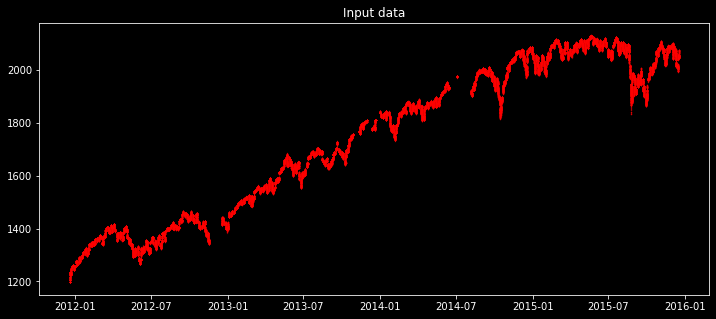

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(12,5))
plt.plot(data.close, 'o', markersize=.3, color='red', alpha=.6)
plt.title('Input data')
plt.show()

In [5]:
def pearson_corr(a,b):
    """
    Better to use scipy
    :param a:
    :param b:
    :return:
    """
    a_hat = np.mean(a)
    b_hat = np.mean(b)
    return np.sum(np.subtract(a, a_hat) * np.subtract(b, b_hat)) / np.sqrt(np.sum(np.square(np.subtract(a, a_hat))) * np.sum(np.square(np.subtract(b, b_hat))))

def _start_duplicates_removing(inp_data):
    #   Clean duplicates
    ret_data = inp_data.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
    #   Check success of cleaning
    assert len(ret_data.index) == len(ret_data.index.unique())
    print(f'Duplicates at {1 - (ret_data.shape[0] / inp_data.shape[0]):.2%} of data')
    return ret_data

def normalize_data(inp_data: pd.DataFrame, show=True):
    #   Calculate the right numbers of observations intra day
    NORMAL_MINUTES = (15 - 9) * 60 + 59 - 29
    #   Checks for duplicates
    if show:
        plt.style.use('dark_background')
        plt.figure(figsize=(12,8))
        plt.subplot(2,1,1)
        plt.plot(inp_data.close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Input data')

    if len(inp_data.index) != len(inp_data.index.unique()):
        inp_data = _start_duplicates_removing(inp_data)
    #   In data not of all information about trade-day. For example at date 2011-12-19 data ends at 15:59. At date 2015-12-19 data ends at 16:14. Notice that normal trade day ends at 16:30.
    #   At start lets drop lines with days with zero observations.
    mask = ~np.in1d(inp_data.index.date,inp_data.resample('1D').count().query(f'open < {NORMAL_MINUTES}').index.date)

    if show:
        plt.subplot(2,1,2)
        plt.plot(inp_data.loc[mask,:].close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Cut data')
        plt.show()
    #   Shows percent of "bad" dotes
    print(f"Bad days at {1 - (len(mask) / len(inp_data)):.2%} observations")
    return inp_data.loc[mask,:]


In [5]:
preprocessed_data = normalize_data(data).close.values

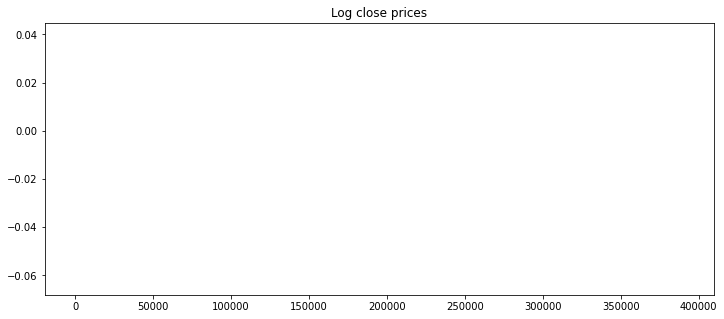

In [9]:
preprocessed_data = np.log((preprocessed_data / np.roll(preprocessed_data, 1))[1:])
plt.figure(figsize=(12,5))
plt.title('Log close prices')
plt.plot(preprocessed_data, '--', color='white')
plt.show()

In [68]:
"""
CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
_LOOKBACK_MASK_ = np.arange(20, 2000, 5)
_HOLD_MASK_ = np.arange(20, 2000, 5)
LB_SIMPLIFY = 10
for WINDOW_LOOKBACK in tqdm(_LOOKBACK_MASK_, desc='WINDOWS_LOOKBACK'):
    LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
    for WINDOW_HOLD in tqdm(_HOLD_MASK_, leave=False, desc='WINDOW_HOLD'):
        HOLD_ALL_DATA = list()
        LOOKBACK_ALL_DATA = list()
        for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):
            if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):
                # print('READY')
                # print(LB_SAMPLE)
                # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)
                # print(WINDOW_HOLD)
                # print(len(preprocessed_data))
                break
            else:
                #   View like [ 20000 20020 ][ 20020 20040 ]
                LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
                HOLD = preprocessed_data[(LB_SAMPLE+1)*WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD]
                HOLD_ALL_DATA.append(sum(HOLD))
                LOOKBACK_ALL_DATA.append(sum(LOOKBACK))
            #print('[',LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK,'][',(LB_SAMPLE+1)*WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD,']')
        PR = pearsonr(LOOKBACK_ALL_DATA, HOLD_ALL_DATA)
        CORRELATION_DF = CORRELATION_DF.append([{'Pair': f"L-{WINDOW_LOOKBACK};H-{WINDOW_HOLD}", 'LOOKBACK': str(WINDOW_LOOKBACK), 'HOLD': str(WINDOW_HOLD), 'Correlation': PR[0], 'P_VALUE': PR[1]}], ignore_index=True)
CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)
"""

WINDOWS_LOOKBACK:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/396 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
def create_corr_table(preprocessed_data):
    CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
    _LOOKBACK_MASK_ = np.arange(20, 200, 5)
    _HOLD_MASK_ = np.arange(20, 200, 5)
    LB_SIMPLIFY = 100
    for WINDOW_LOOKBACK in tqdm(_LOOKBACK_MASK_, desc='WINDOWS_LOOKBACK'):

        LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
        for WINDOW_HOLD in tqdm(_HOLD_MASK_, leave=False, desc='WINDOW_HOLD'):
            HOLD_ALL_DATA = list()
            LOOKBACK_ALL_DATA = list()
            for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):
                if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):
                    # print('READY')
                    # print(LB_SAMPLE)
                    # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)
                    # print(WINDOW_HOLD)
                    # print(len(preprocessed_data))
                    break
                else:
                    #   View like [ 20000 20020 ][ 20020 20040 ]
                    LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
                    HOLD = preprocessed_data[(LB_SAMPLE+1)*WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD]
                    HOLD_ALL_DATA.append(sum(HOLD))
                    LOOKBACK_ALL_DATA.append(sum(LOOKBACK))
                #print('[',LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK,'][',(LB_SAMPLE+1)*WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD,']')
            PR = pearsonr(LOOKBACK_ALL_DATA, HOLD_ALL_DATA)
            CORRELATION_DF = CORRELATION_DF.append([{'Pair': f"L-{WINDOW_LOOKBACK};H-{WINDOW_HOLD}", 'LOOKBACK': str(WINDOW_LOOKBACK), 'HOLD': str(WINDOW_HOLD), 'Correlation': PR[0], 'P_VALUE': PR[1]}], ignore_index=True)
    return CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)

df = create_corr_table(preprocessed_data=preprocessed_data)
df

WINDOWS_LOOKBACK:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

WINDOW_HOLD:   0%|          | 0/36 [00:00<?, ?it/s]

,Pair,LOOKBACK,HOLD,Correlation,P_VALUE
1173,L-180;H-125,180,125,0.537495,0.009886
1171,L-180;H-115,180,115,0.536599,0.010033
1170,L-180;H-110,180,110,0.536415,0.010064
764,L-125;H-60,125,60,0.528575,0.001871
767,L-125;H-75,125,75,0.521883,0.002188
...,...,...,...,...,...
1239,L-190;H-95,190,95,-0.489415,0.024336
1237,L-190;H-85,190,85,-0.489557,0.024288
1235,L-190;H-75,190,75,-0.492344,0.023371
1260,L-195;H-20,195,20,-0.493727,0.022926


In [20]:
def creator(WINDOW_LOOKBACK, _HOLD_MASK_, preprocessed_data, LB_SIMPLIFY):
    RETURN_LIST = list()
    LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
    for WINDOW_HOLD in _HOLD_MASK_:
        HOLD_ALL_DATA = list()
        LOOKBACK_ALL_DATA = list()
        for LB_SAMPLE in range(0, LB_SAMPLES, LB_SIMPLIFY):
            if (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD > len(preprocessed_data):
                # print('READY')
                # print(LB_SAMPLE)
                # print((LB_SAMPLE + 1) * WINDOW_LOOKBACK)
                # print(WINDOW_HOLD)
                # print(len(preprocessed_data))
                break
            else:
                #   View like [ 20000 20020 ][ 20020 20040 ]
                LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
                HOLD = preprocessed_data[(LB_SAMPLE+1)*WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD]
                HOLD_ALL_DATA.append(sum(HOLD))
                LOOKBACK_ALL_DATA.append(sum(LOOKBACK))
            #print('[',LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK,'][',(LB_SAMPLE+1)*WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK+WINDOW_HOLD,']')
        PR = pearsonr(LOOKBACK_ALL_DATA, HOLD_ALL_DATA)
        RETURN_LIST.append({'Pair': f"L-{WINDOW_LOOKBACK};H-{WINDOW_HOLD}", 'LOOKBACK': str(WINDOW_LOOKBACK), 'HOLD': str(WINDOW_HOLD), 'Correlation': PR[0], 'P_VALUE': PR[1]})
    return RETURN_LIST

def threading_create_corr_table(preprocessed_data):
    CORRELATION_DF = pd.DataFrame(columns=['Pair','LOOKBACK','HOLD','Correlation', 'P_VALUE'])
    _LOOKBACK_MASK_ = np.arange(20, 200, 5)
    _HOLD_MASK_ = np.arange(20, 200, 5)
    LB_SIMPLIFY = 100

    assets = Parallel(n_jobs=-1, verbose=10)(delayed(creator)(WINDOW_LOOKBACK, _HOLD_MASK_, preprocessed_data, LB_SIMPLIFY) for WINDOW_LOOKBACK in _LOOKBACK_MASK_)
    for _ in assets:
        for __ in _:
            CORRELATION_DF = CORRELATION_DF.append([__], ignore_index=True)

    return CORRELATION_DF.sort_values(by=['Correlation'],ascending=False)

df2 = threading_create_corr_table(preprocessed_data=preprocessed_data)
df2.query('Correlation < 0.7')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:    6.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    6.6s finished


,Pair,LOOKBACK,HOLD,Correlation,P_VALUE
1173,L-180;H-125,180,125,0.537495,0.009886
1171,L-180;H-115,180,115,0.536599,0.010033
1170,L-180;H-110,180,110,0.536415,0.010064
764,L-125;H-60,125,60,0.528575,0.001871
767,L-125;H-75,125,75,0.521883,0.002188
...,...,...,...,...,...
1239,L-190;H-95,190,95,-0.489415,0.024336
1237,L-190;H-85,190,85,-0.489557,0.024288
1235,L-190;H-75,190,75,-0.492344,0.023371
1260,L-195;H-20,195,20,-0.493727,0.022926


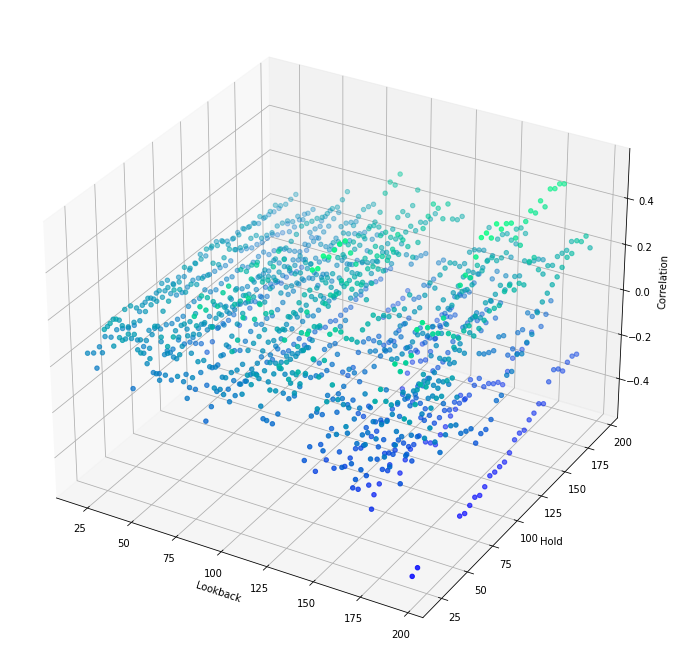

In [53]:
from matplotlib import cm
ax = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
ax.set_xlabel('Lookback')
ax.set_ylabel('Hold')
ax.set_zlabel('Correlation')
X, Y = np.meshgrid(df['LOOKBACK'].astype(float), df['HOLD'].astype(float))
ax.scatter(df['LOOKBACK'].astype(float), df['HOLD'].astype(float), df['Correlation'],c=df['Correlation'], cmap=plt.get_cmap('winter'))

In [1]:
#   Testing that A U B == 0
plt.figure(figsize=(14,6))
LB_SIMPLIFY = 1
WINDOW_LOOKBACK = 30000
LB_SAMPLES = len(preprocessed_data) // WINDOW_LOOKBACK
colors = rainbow(np.linspace(0,1, len(range(0, LB_SAMPLES, LB_SIMPLIFY))))
for i, LB_SAMPLE in enumerate(range(0, LB_SAMPLES, LB_SIMPLIFY)):
    LOOKBACK = preprocessed_data[LB_SAMPLE * WINDOW_LOOKBACK: (LB_SAMPLE+1)*WINDOW_LOOKBACK]
    plt.plot([j for j in range(LB_SAMPLE * WINDOW_LOOKBACK, (LB_SAMPLE+1)*WINDOW_LOOKBACK)], LOOKBACK,'--', color=colors[i])
plt.show()


NameError: name 'plt' is not defined

,Pair,Correlation
0,2020,23
